In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from scipy.ndimage import convolve, generate_binary_structure
from numba import njit, prange
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm

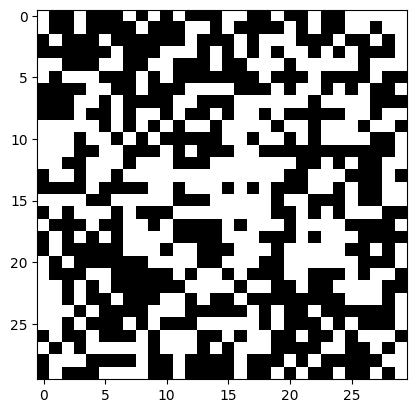

In [2]:
# Initial State example
def randomstate(N):
    return 2 * np.random.randint(2, size=(N, N)) - 1
N = 30
lattice = randomstate(N)
plt.imshow(lattice , cmap = 'binary_r')

In [3]:
def get_energy(lattice):
    # applies the nearest neighbours summation
    kern = generate_binary_structure(2, 1) 
    kern[1][1] = False
    arr = -lattice * convolve(lattice, kern, mode='constant', cval=0)
    return arr.sum()
get_energy(lattice)

-120

In [4]:
#Metropolis algorithm
@njit(parallel=True) # looping
def metropolis_step(lattice, T):
    for _ in prange(N * N):
        x, y = np.random.randint(0, N), np.random.randint(0, N)
        deltaE = 2 * lattice[x, y] * (lattice[(x + 1) % N, y] + lattice[x, (y + 1) % N] + 
                       lattice[(x - 1) % N, y] + lattice[x, (y - 1) % N])
        if deltaE < 0:
            lattice[x, y] *= -1
        elif np.random.rand() < np.exp(-deltaE / T):
            lattice[x, y] *= -1

In [5]:
# Critical Temperature Lars Onsager
Bc = 0.5 * np.log(1 + np.sqrt(2))
Tc = 1/Bc
print(f'The critical temperature is {Tc}')

The critical temperature is 2.269185314213022


In [6]:
Msteps, Esteps, ntemp = [5000, 2000, 2000]
T = np.linspace(1., 3.5, ntemp)
magnetization = []

In [7]:
# Initializing spins and labels
spins, labels = np.zeros((0, N * N)), np.zeros((0, 2))
high, low = np.array([1, 0]), np.array([0, 1])

In [8]:
for index, temp in enumerate(tqdm(T)):
    tmp = []

    for _ in range(Esteps):
        metropolis_step(lattice, temp)

    # Loop over spin configurations
    for mc in range(Msteps):
        if mc % 200 == 0:
            tmp.append(np.sum(lattice))
        metropolis_step(lattice, temp)
    spins = np.vstack((spins, lattice.ravel()))

    if temp < Tc:
        labels = np.vstack((labels, low))
    else:
        labels = np.vstack((labels, high))

    magnetization.append(np.mean(tmp) / (N * N))

# Save data
def save(object, filename):
    with open(filename + '.pickle', 'wb') as f:
        pickle.dump(object, f)
save(0.5 * (spins + 1), 'train_spins'), save(labels, 'train_labels'), save(T, 'temperature')

100%|██████████| 2000/2000 [10:07<00:00,  3.29it/s]


(None, None, None)

In [9]:
# Loading data
def load(filename):
    with open(filename + '.pickle', 'rb') as f:
        return pickle.load(f)

data_x = load('train_spins')
temp = load('temperature')
dim = len(temp)

In [10]:
training_epochs = 100

# Network Parameters
n_hidden_1 = 2 * N* N
n_input = N * N
n_classes = 2

In [11]:
tf.random.set_seed(42)
tf.compat.v1.disable_eager_execution()
x = tf.compat.v1.placeholder("float", [None, n_input])
y = tf.compat.v1.placeholder("float", [None, n_classes])

In [12]:
weights = {
    'h1': tf.Variable(tf.random.normal([n_input, n_hidden_1])),
    'out': tf.Variable(tf.random.normal([n_hidden_1, n_classes]))
}
biases = {
    'b1': tf.Variable(tf.constant(0.1, shape=[n_hidden_1])),
    'out': tf.Variable(tf.constant(0.1, shape=[n_classes]))
}

In [13]:
# Model

def single_sigmoid(x, weights, biases):
    layer_1 = tf.sigmoid(tf.matmul(x, weights['h1']) + biases['b1'])
    out_layer = tf.matmul(layer_1, weights['out']) + biases['out']
    return out_layer

def initialize_model(x, weights, biases):

    # Construct model, define cost and optimizer
    pred = single_sigmoid(x, weights, biases)
    cost = tf.reduce_mean(tf.compat.v1.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y))
    regularizer = tf.nn.l2_loss(weights['h1']) + tf.nn.l2_loss(weights['out'])
    cost = tf.reduce_mean(cost + l2 * regularizer)
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    return pred, cost, optimizer

  0%|          | 0/80 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
100%|██████████| 80/80 [18:43<00:00, 14.05s/it]


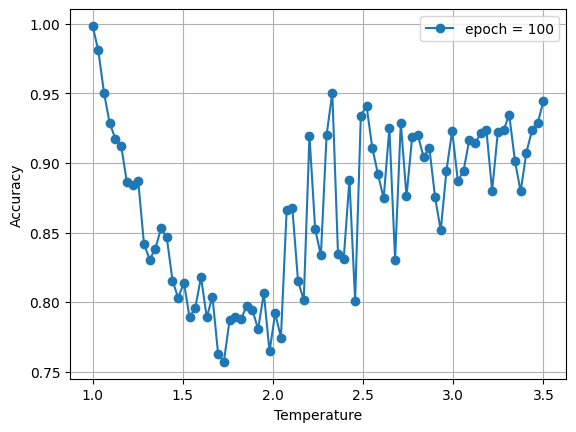

In [15]:
learning_rate = 1e-3
l2 = 1e-4
step = 25 # Step in confusion scheme
accuracy = []


# Loop over proposed critical temperatures
for pos in tqdm(range(0, dim, step)):


    # Initializing the variables
    pred, cost, optimizer = initialize_model(x, weights, biases)
    sess = tf.compat.v1.InteractiveSession()
    tf.compat.v1.global_variables_initializer().run()

    # Generate label for training
    low = np.array([[0] * (dim - pos), [1] * (dim - pos)]).T
    high = np.array([[1] * pos, [0] * pos]).T
    data_y = np.vstack((low, high))

    # Take subset of data for training
    train_x, _, train_y, _ = train_test_split(data_x, data_y, 
                                              train_size=0.25, random_state=42)
    
    for epoch in range(100):

        perm = np.arange(len(train_x))
        np.random.shuffle(perm)
        train_x, train_y = train_x[perm], train_y[perm]

        # Train network
        _, c = sess.run([optimizer, cost], feed_dict={x: train_x, y: train_y})


    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    accuracy_tmp = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    accuracy.append(accuracy_tmp.eval({x: data_x, y: data_y}))
    sess.close()


a = np.linspace(1., 3.5, len(accuracy))
plt.plot(a, accuracy, '-o', label = 'epoch = 100')
plt.xlabel('Temperature')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.savefig(f'{learning_rate}-{l2}.png')

In [17]:
# Max accuracy

alpha = [x for x in accuracy[30:60]]
def find_max(z):
  vector = []
  for i, j in enumerate(z):
    if j == np.max(alpha):
        vector.append(i)
  return np.max(vector)

Tc_pred = a[find_max(accuracy[30:60])+30]
acc = np.max(accuracy[30:60])
print("The predicted critical temperature is {}".format(Tc_pred), 
      " with accuracy {}".format(acc), " | temperature error is {}".format((Tc_pred - Tc)/Tc))

The predicted critical temperature is 2.329113924050633  with accuracy 0.9505000114440918  | temperature error is 0.026409746908834866
